<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/Exercise_7_Bayes_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Download & prepare the dataset

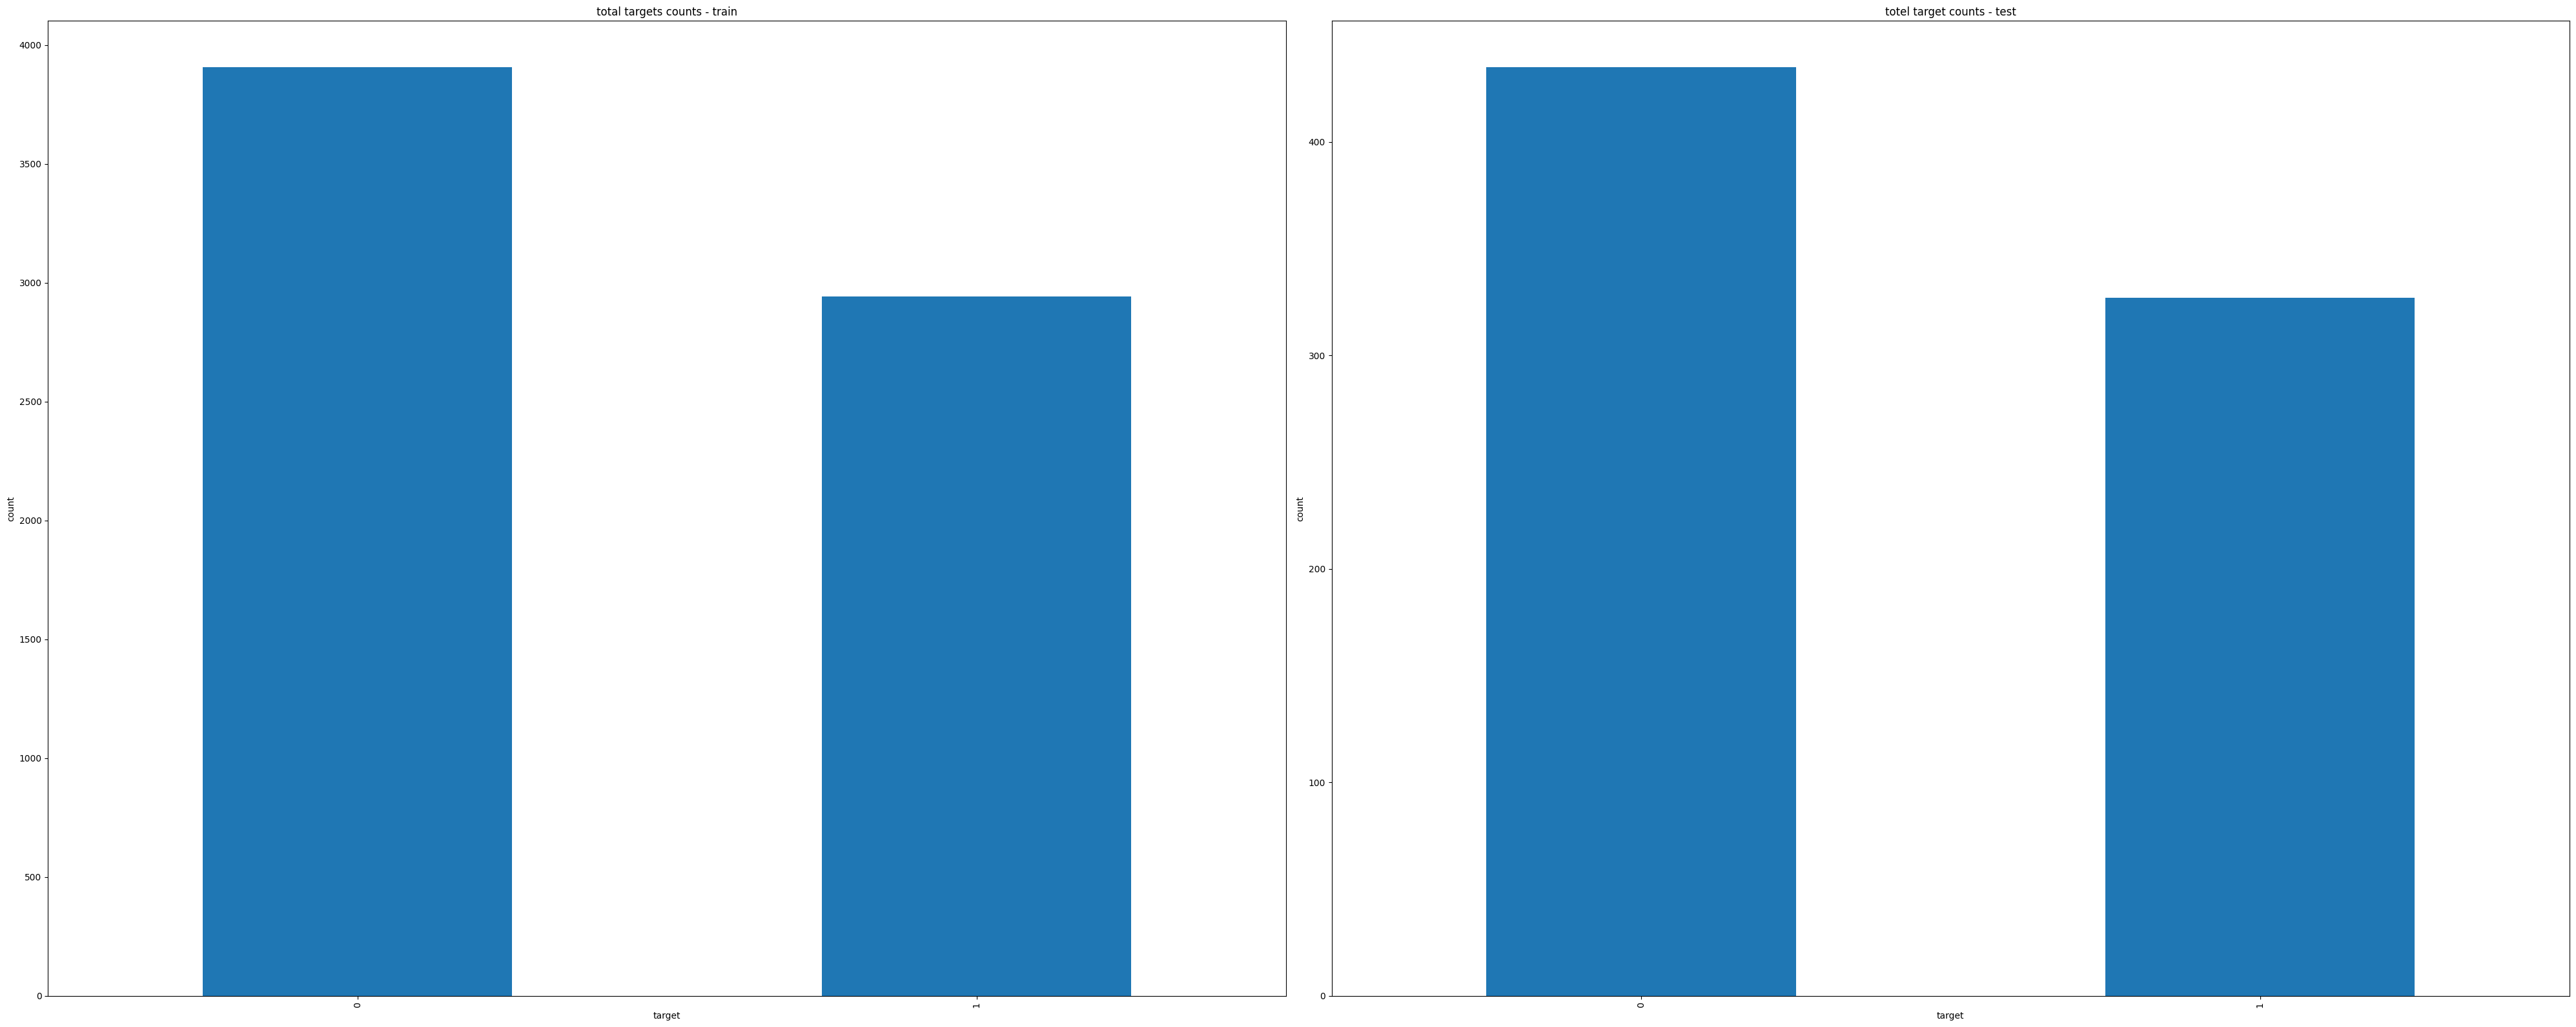



train proportions: target
0    0.570282
1    0.429718
Name: proportion, dtype: float64


test proportions: target
0    0.570866
1    0.429134
Name: proportion, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/train.csv")

train_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["target"],
    random_state=0
)

fig, axes = plt.subplots(1, 2, figsize=(40, 16))
train_df["target"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("total targets counts - train")
axes[0].set_xlabel("target")
axes[0].set_ylabel("count")

test_df["target"].value_counts().sort_index().plot(kind="bar", ax=axes[1])
axes[1].set_title("totel target counts - test")
axes[1].set_xlabel("target")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

train_counts = train_df["target"].value_counts(normalize=True).sort_index()
test_counts  = test_df["target"].value_counts(normalize=True).sort_index()
print("\n\ntrain proportions:", train_counts)
print("\n\ntest proportions:", test_counts)


The dataset is obviously inbalanced, though without huge difference (57-43). Though, we added the 'stratify' option in the training method to handle that moving onwards.

# Step 2: Aggregated & preprocess the dataset features

In [2]:
# dropping id feature both from training and testing sets
train_df = train_df.drop(columns=["id", "location"])
test_df  = test_df.drop(columns=["id", "location"])

# filling all NaN with null
train_df = train_df.fillna("null")
test_df  = test_df.fillna("null")

# concatenate keyword + text features under one feature named as inputs (both sets)
train_df["inputs"] = train_df["keyword"].astype(str) + " " + train_df["text"].astype(str)
test_df["inputs"]  = test_df["keyword"].astype(str)  + " " + test_df["text"].astype(str)

train_df.head()


,keyword,text,target,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,0,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,0,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,0,hazardous Is it possible to sneak into a hospi...


# Step 3: Text cleaning using Deffro prepro repo

In [3]:
!rm -rf text-preprocessing-techniques
!git clone https://github.com/Deffro/text-preprocessing-techniques.git

Cloning into 'text-preprocessing-techniques'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (35/35), 2.42 MiB | 35.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
import os, sys, nltk
repo_dir = "/content/text-preprocessing-techniques"
os.chdir(repo_dir)
sys.path.append(repo_dir)

# prerequisite NLTK resources neede by the Deffro repo
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

# importing the techniques (the ones I read in the repo description)
from techniques import (
    removeUnicode,
    replaceURL,
    replaceAtUser,
    removeHashtagInFrontOfWord,
    replaceContraction,
    removeNumbers,
    replaceMultiExclamationMark,
    replaceMultiQuestionMark,
    replaceMultiStopMark,
    removeEmoticons,
)

# create an object of mass techniques usage
cleaning_steps = [
    ("removeUnicode", removeUnicode),
    ("replaceURL", replaceURL),
    ("replaceAtUser", replaceAtUser),
    ("removeHashtagInFrontOfWord", removeHashtagInFrontOfWord),
    ("replaceContraction", replaceContraction),
    ("removeNumbers", removeNumbers),
    ("replaceMultiExclamationMark", replaceMultiExclamationMark),
    ("replaceMultiQuestionMark", replaceMultiQuestionMark),
    ("replaceMultiStopMark", replaceMultiStopMark),
    ("removeEmoticons", removeEmoticons),
]

# i am not uisng the raw/original datasets for safety (not to loose the original/core pair)
# so I'm passing them as string to a new one for the following steps
train_df["clean_inputs"] = train_df["inputs"].astype(str)
test_df["clean_inputs"]  = test_df["inputs"].astype(str)

for _, fn in cleaning_steps:
    train_df["clean_inputs"] = train_df["clean_inputs"].apply(fn)
    test_df["filtereclean_inputsd_inputs"]  = test_df["clean_inputs"].apply(fn)

# formatting the final dataset excluding the whitespace
train_df["clean_inputs"] = train_df["clean_inputs"].str.split().str.join(" ")
test_df["clean_inputs"]  = test_df["clean_inputs"].str.split().str.join(" ")

train_df[["inputs", "clean_inputs"]].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/text-preprocessing-techniques/techniques.py:20: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/content/text-preprocessing-techniques/techniques.py:26: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)
/content/text-preprocessing-techniques/techniques.py:96: SyntaxWarning: invalid escape sequence '\g'
  contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
/content/text-preprocessing-techniques/techniques.py:96: SyntaxWarning: invalid escape sequence '\g'
  contraction_patterns = [ (r'won\'t

,inputs,clean_inputs
6669,threat Meek Mill responds to DrakeÛªs OVO Fes...,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood survived the plague\nfloated the flood\n...,flood survived the plague floated the flood ju...
7217,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...,weapons Kick Hendrixonfire atUser | BIG NOOB C...
2234,deluge Vince McMahon once again a billionaire:...,deluge Vince McMahon once again a billionaire ...
4233,hazardous Is it possible to sneak into a hospi...,hazardous Is it possible to sneak into a hospi...


For the code section above I used the following techniques:
<br>


1.   **Remove UNI code**: simply removes the unicode, (such as emojis/symbols) that can produce unnecessary noise in the core content.
2.   **Replace URL**: replaces all URLs with a fixed token (instead of having a URL as '*https://...*' this will be added *[LINK]*, or "*< URL >*" - that way the parsing is getting easier without any problem, and the keywords of the URL itself are not affecting the anaysis).
3.   **Replace @/User**: simply replaces mentions and user related noise (I don't care about WHO was mentioned, by IF someone was mentioned - that said, we replace *@JimPapadopoulos* with *@USER* for instance).
4.   **Replace contractions**: that's all about transforming "can't" to "*can no*t", or "*I'm*" to "*I am*". If we wan't do that, then "*can't*" and "can not" are consindered a different token, while it's the same.
5.   **Remove numbers**: someone could say that this is weird rule, but numbers often do not provide any core info about our processing, numbers can rarely repeated (so no much of value here) and also if we keep all numbers, then each number will have its token (low value for high cost), for example from "*I am 15 years old*" to "*I am years old*".
6.   **Replace exclamation mark**: replacing (!) with a keyword that will be tokenized once and will be & mean the same everytime an exclamation mark is found (i.e., *< EXCLAMATION >* or *< EMPHASIZING >*).
7.   **Replace question mark**: same thing as the rule no6 (excalamation mark) though for the question mark instead.
8.   **Replace question mark**: same as the question or exclamation mark, though with the multi-stop this time (i.e, "*we will see...*" to "*we will see < ELLIPSIS > or < MULTI-STOP >*).
9.   **Remove emoticons**: s removing " *[ :) ]*, *[ (: ]*, *[ :-) ]* " or other emoticons. They don't offer value, they can be presented by multiple variations (diff. tokens) and they bring noise.

# Step 4: Separate inputs and targets to NumPy arrays

In [5]:
import numpy as np

x_train_txt = train_df["clean_inputs"].to_numpy()
y_train = train_df["target"].to_numpy().astype(int)

x_test_txt = test_df["clean_inputs"].to_numpy()
y_test = test_df["target"].to_numpy().astype(int)

print(x_train_txt.shape, y_train.shape, x_test_txt.shape, y_test.shape)


(6851,) (6851,) (762,) (762,)


# Step 5: TF-IDF vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
    max_features=50000, # the higher the worst in terms of speed
    ngram_range=(1, 2), # creating features for all 1-word [ngram_range=1] and 2-word sequences [ngram_range=2]
    min_df=2 # ignore rare terms
)

"""

>>> min_df=2: ignores terms that appear in less than 2 documents (helps reducing noise and rare bigrams)

>>> ngram_range=(1, 2): captures unigraps and bigrams, helping to:

    Positive:
    [1] capture context and meaning
    [2] Improves performance on short txts (bigrams)
    [3] handles negation better (bigrams ofent preserve negations)

    ------------------------------------------------------------------------------------

    Negative:
    [a] A negative aspect is that the training time is taking longer and more memory is needed
    since, for 20k unigrams, we would need 200k bigrams
    [b] Finally, there is a risk of overfitting (great fit, but loosing new terms); that's why
    is not recommended for long-text documents, but is ideal for short-term ones like in our case

"""


x_train = tf_idf.fit_transform(x_train_txt)
x_test  = tf_idf.transform(x_test_txt)

print("TF-IDF shape results:", x_train.shape, x_test.shape)


TF-IDF shape results: (6851, 16911) (762, 16911)


# Step 6: SVM-linear (LinearSVC)

In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

linear_svc = LinearSVC(random_state=0)
linear_svc.fit(x_train, y_train)

def model_evaluation(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

train_pred = linear_svc.predict(x_train)
test_pred  = linear_svc.predict(x_test)

train_metrics = model_evaluation("LinearSVC with train", y_train, train_pred)
test_metrics  = model_evaluation("LinearSVC with test", y_test, test_pred)

print("LinearSVC training results:", train_metrics)
print("LinearSVC testing results: ", test_metrics)

LinearSVC training results: {'model': 'LinearSVC with train', 'accuracy': 0.9709531455262006, 'f1': 0.9656244601831059, 'precision': 0.9824253075571178, 'recall': 0.9493885869565217}
LinearSVC testing results:  {'model': 'LinearSVC with test', 'accuracy': 0.7939632545931758, 'f1': 0.7413509060955519, 'precision': 0.8035714285714286, 'recall': 0.6880733944954128}


I believe that recall is the most important metric in this case, since failing to identify a real disaster case through the tweets is going to be way more costly compared to a false alarm.

# Step 7: PCA + SVM meet eachother

In [8]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# transform dense arrays to fit PCA
x_train_dense = x_train.toarray()
x_test_dense  = x_test.toarray()

pca = PCA(n_components=0.95, random_state=0)  # keep 95% variance (information, not 95% components)
x_train_pca = pca.fit_transform(x_train_dense)
x_test_pca  = pca.transform(x_test_dense)

print("In order to keep 95% of info meaning, we need the following num of components:", pca.n_components_)
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())

model_linsvc_pca = LinearSVC(random_state=0)
model_linsvc_pca.fit(x_train_pca, y_train)

train_pred_linsvc_pca = model_linsvc_pca.predict(x_train_pca)
test_pred_linsvc_pca  = model_linsvc_pca.predict(x_test_pca)

print("PCA train for all the models:", model_evaluation(" -- ", y_train, train_pred_linsvc_pca))
print("LinearSVC + PCA test:", model_evaluation("LinearSVC + PCA test", y_test, test_pred_linsvc_pca))

model_svc_rbf_pca = SVC(kernel="rbf", gamma="scale", random_state=0)
model_svc_rbf_pca.fit(x_train_pca, y_train)

train_pred_svc_w_rbf_pca = model_svc_rbf_pca.predict(x_train_pca)
test_pred_svc_w_rbf_pca  = model_svc_rbf_pca.predict(x_test_pca)

print("SVC (rbf) + PCA test:", model_evaluation("SVC (rbf) + PCA test", y_test, test_pred_svc_w_rbf_pca))


In order to keep 95% of info meaning, we need the following num of components: 3984
Explained variance ratio sum: 0.9500241975808954
PCA train for all the models: {'model': ' -- ', 'accuracy': 0.9490585316012261, 'f1': 0.9389753453400944, 'precision': 0.9675675675675676, 'recall': 0.9120244565217391}
LinearSVC + PCA test: {'model': 'LinearSVC + PCA test', 'accuracy': 0.7965879265091863, 'f1': 0.743801652892562, 'precision': 0.8093525179856115, 'recall': 0.6880733944954128}
SVC (rbf) + PCA test: {'model': 'SVC (rbf) + PCA test', 'accuracy': 0.8267716535433071, 'f1': 0.78, 'precision': 0.8571428571428571, 'recall': 0.7155963302752294}


I used **TF-IDF vectorization** to convert the preprocessed tweets and assign higher importance to words that are more frequent in a specific object (in my case a tweet) though a bit rare holistically. That helped me to support the discriminative patterns and represent them in a better way (worked as a middle layer before PCA providing a semantic structure of data for it). The results from TF-IDF phase were used later on by the PCA.



Thus, **PCA** used to get me back the minimum needed components that can generalize and explain at least 95% of the useful info (variance).

In my case, to explain 95% of the info, at least 3984 components were needed. That high feature number is also explained by the high dimensionality results that existed post TF-IDF usage.

For future improvement, I could use CV (cross-validation). For that, I would need to tune the C and gamma attributes, which means that I should try and find the most optimum hyperparameters set.

Post TF-IDF and PCA the following models were used:


*   LinearSVC
*   SVC using the rbf kernel


When it comes to the training results, the recall result was 0.912 (91.2%) and the accuracy was 0.949 (94.9%). With a first look, there is a high possibility of having overfitting.

Moving onwards, the testing results were slightly different as:



*   LinearSVC
    * accuracy: 79.7%
    * F1: 74.4%
    * precision: 80.9%
    * recall: 68.8%
2.  SVC (kernel=rbf)
    * accuracy: 82.7%
    * F1: 78.0%
    * precision: 85.7%
    * recall: 71.6%

It's more than obvious that SVC (rbf) outperforms the linear version in all the metrics. And it's logical, would be really unexpected to see linear perfection in such a dataset even after TF-IDF applied.

Also, not only is better in the metrics, but is also better in one of the most important metrics for this scenario, which is recall (reason for that explained above already).

Though, after a deep analysis it's obvious that we don't have overfitting results but really good generalization (identical training performance and better test performance for both models).




# Step 8: Gamma attribute playground

                       accuracy        f1  precision    recall
model                                                         
LinearSVC              0.793963  0.741351   0.803571  0.688073
LinearSVC + PCA        0.796588  0.743802   0.809353  0.688073
SVC (rbf-scale) + PCA  0.826772  0.780000   0.857143  0.715596
SVC (rbf-auto) + PCA   0.570866  0.000000   0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


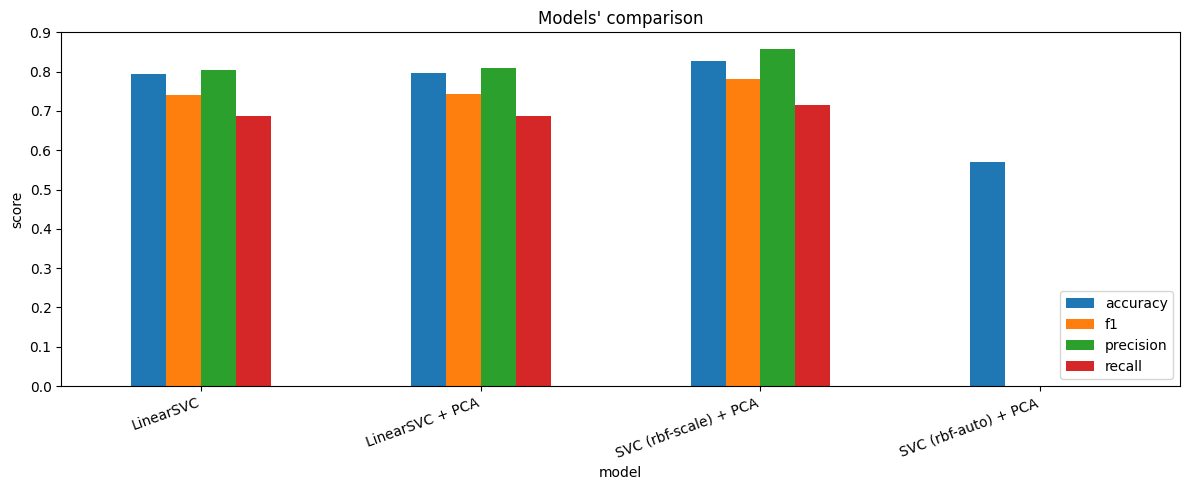


Gamma formulas:
Here (post PCA): n_features=3984, x.var()≈0.000236
gamma(scale)≈1.063072, gamma(auto)=0.000251


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# gamma expl:
# - 'scale' = 1 / (n_features * x.var())
# - 'auto'  = 1 / n_features

model_svc_rbf_pca_auto = SVC(kernel="rbf", gamma="auto", random_state=0)
model_svc_rbf_pca_auto.fit(x_train_pca, y_train)

test_pred_svc_pca_auto = model_svc_rbf_pca_auto.predict(x_test_pca)

results = []
results.append(model_evaluation("LinearSVC", y_test, test_pred))
results.append(model_evaluation("LinearSVC + PCA", y_test, test_pred_linsvc_pca))
results.append(model_evaluation("SVC (rbf-scale) + PCA", y_test, test_pred_svc_w_rbf_pca))
results.append(model_evaluation("SVC (rbf-auto) + PCA", y_test, test_pred_svc_pca_auto))

res_df = pd.DataFrame(results).set_index("model")
print(res_df)

# bar plot per metric
metrics = ["accuracy", "f1", "precision", "recall"]
ax = res_df[metrics].plot(kind="bar", figsize=(12, 5))
ax.set_ylabel("score")
ax.set_title("Models' comparison")
ax.legend(loc="lower right")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# results of gamma parameter
n_features = x_train_pca.shape[1]
xvar = x_train_pca.var()
print("\nGamma-only results:")
print(f"gamma(scale)≈{1/(n_features*xvar):.6f}, gamma(auto)={1/n_features:.6f}")


That was a big unexpected to be honest. So, the SVC with kernel (rbf) and gamma=auto predicted only the majority class. That means that precision, recall and F1 for the possitive class will be zero, while accuracy stayed positive (57% which was the % of the class 0 representation) because of having class inbalance. Another reason why accuracy is not a good metric by its own.

Despite the fact that the accuracy is medium to slighly good, **this model should be rejected for good**!! So, accuracy will need to be double-check especially when classes are inbalanced.

Also, from this example we can see that:
- [1] gamma should be set to scale,
- [2] more than 1 metric are needed to double-check that the model is working or not and
- [3] finally we need to experiment with the SVM hyperparameters to finalize our results and mark them either good or bad.

<br>

---

<br>

So give the example above:

1. if gamma is small, then we have more influence and easier/smoothier decision boundary
2. if gamma is large, then we have less influence and very rough boundary

That said, if gamma=auto, then its formula is:


```
gamma = 1 / n_features
```

That type of gamma is only depended on the total number of features (ignoring the value of the features themselves).

On the contrary, if gamma=scale, then its forumla is:



```
gamma = 1 / (n_features * varianceOfX)
```

That type of gamma is depended on the number of features AND the variance of the data (adapts per feature scaling), making it a really really sensitive parameter.

<br>

---

<br>

**Summary**:
- scale cares about the features number and how much spread the data is
- auto looks only the faetures number and nothing else





# Step 9: Repeat from Step 6 and onwards using Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

# GaussianNB requires dense input
x_train_gnb = x_train.toarray()
x_test_gnb  = x_test.toarray()

gnb = GaussianNB()
gnb.fit(x_train_gnb, y_train)

train_pred_gnb = gnb.predict(x_train_gnb)
test_pred_gnb  = gnb.predict(x_test_gnb)

print("Training with:", model_evaluation("GaussianNB", y_train, train_pred_gnb))
print("Testing with: ", model_evaluation("GaussianNB", y_test, test_pred_gnb))


Training with: {'model': 'GaussianNB', 'accuracy': 0.9312509122755802, 'f1': 0.9252262263851405, 'precision': 0.8685543964232488, 'recall': 0.9898097826086957}
Testing with:  {'model': 'GaussianNB', 'accuracy': 0.699475065616798, 'f1': 0.6901217861975643, 'precision': 0.6189320388349514, 'recall': 0.7798165137614679}


About the Bayes results we can see the following:


*   Training
    * accuracy: 93.12%
    * F1: 92.52%
    * precision: 86.85%
    * recall: 98.99%   
*   Testing
    * accuracy: 69.94%
    * F1: 69.01%
    * precision: 61.89%
    * recall: 77.98%

THe most significant metric from the training data is the recall. That's a bit ideal since it seems that Bayes can predict all disaster tweets from the training. It's one of the most important factos to remember about Bayes, that the false negative are minimized in a rough way. Also, tends to give more favor to the positive class (if evidence/disaster exists).

Also, on the test results, the dros of the accuracy (24%), precision (25%) and the F1 score (23%) are big. That means that the model is not generalizing really good. High overfitting outcome.

<br>

---

<br>

**Summary**:

Bayes trains well on the training set, because of its tendency to predict the positive class, leating to high recall. Though, the performance drops really bad on the test set due to Gaussian distribution assumptions becaue its violated by the TF-IDF sparse features (many values are 0 and that said is not normally distributed, and many skewed representations are expected). So, the results are poorer compared to the SVM models that work way way better due to high-dimensional txt representations.

tip: TF-IDF is a mechanism that apparently boost a lot the disciminative models which are the SVMs.
